In [1]:
import gym
import pylab
import random
import numpy as np
from collections import deque

In [2]:
import os    
os.environ['THEANO_FLAGS'] = "device=cuda*"  
import theano

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType


In [3]:
#Importing keras Dense (fully connected) layer and Sequential model
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

Using Theano backend.


## Task: fill empty spaces in the following agent code

In [4]:
class DeepQAgent:
    def __init__(self, state_size, action_size, render=True):
        # Tip: if you are training this on AWS the best way is to turn off rendering
        # and load it later with the serialized model
        self.render = render
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_min = 0.005
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / 50000
        self.batch_size = 64
        self.train_start = 1000
        # replay memory
        self.memory = deque(maxlen=10000)

        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        # Use tflearn to get simple NN for deep q-learning
        # Spoler alert: a couple of fully connected hidden layers should be enough
        # Output layer should have the same dimensionality as the action space
        
        model = Sequential()
        model.add(Dense(128, input_dim = self.state_size, activation='linear', init='lecun_uniform'))
        model.add(Dense(64, activation='relu', init='lecun_uniform'))
        model.add(Dense(32, activation='relu', init='lecun_uniform'))
        model.add(Dense(self.action_size, activation='linear', init='lecun_uniform'))
        model.compile(optimizer=RMSprop(lr=self.learning_rate), loss='mean_squared_error')
        return model


    def update_target_model(self):
        """Update your target model to the model you are currently learning at regular time intervals"""
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        """The choice of action uses the epsilon-greedy policy for the current network."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def replay_memory(self, state, action, reward, next_state, done):
        """Save <s, a, r, s'> to replay_memory"""
        if action == 2:
            action = 1
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
            # print(len(self.memory))

    def train_replay(self):
        """Random sampling of batch_size samples from replay memory"""
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.action_size))

        for i in range(batch_size):
            state, action, reward, next_state, done = mini_batch[i]
            target = self.model.predict(state)[0]

            # As in queuing, it gets the maximum Q Value at s'. However, it is imported from the target model.
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.discount_factor * \
                                          np.amax(self.target_model.predict(next_state)[0])
            update_input[i] = state
            update_target[i] = target

        # You can create a minibatch of the correct target answer and the current value of your own,
        self.model.fit(update_input, update_target, batch_size=batch_size, epochs=1, verbose=0)

    def load_model(self, name):
        self.model.load_model(name)

    def save_model(self, name):
        self.model.save(name)


In [5]:
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0] # should be equal 2
ACTION_SIZE = 2
agent = DeepQAgent(state_size, ACTION_SIZE)
# agent.load_model("./save_model/<your_saved_model_name>")
scores, episodes = [], []
N_EPISODES = 500

/home/margarita/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="linear", kernel_initializer="lecun_uniform", input_dim=2)`
/home/margarita/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="lecun_uniform")`
/home/margarita/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="lecun_uniform")`
/home/margarita/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, activation="linear", kernel_initializer="lecun_uniform")`
/home/margarita/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="linear", kernel_

In [6]:
for e in range(N_EPISODES):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    print(state)

    # Action 0 (left), 1 (do nothing), 3 (declare fake_action to avoid doing nothing
    fake_action = 0

    # Counter for the same action 4 times
    action_count = 0

    while not done:
        #if agent.render:
        #    env.render()

        # Select an action in the current state and proceed to a step
        action_count = action_count + 1

        if action_count == 4:
            action = agent.get_action(state)
            action_count = 0

            if action == 0:
                fake_action = 0
            elif action == 1:
                fake_action = 2

        # Take 1 step with the selected action
        next_state, reward, done, info = env.step(fake_action)
        next_state = np.reshape(next_state, [1, state_size])
        # Give a penalty of -100 for actions that end an episode
        # reward = reward if not done else -100

        # Save <s, a, r, s'> to replay memory
        agent.replay_memory(state, fake_action, reward, next_state, done)
        # Continue to learn every time step
        agent.train_replay()
        score += reward
        state = next_state

        if done:
            env.reset()
            # Copy the learning model for each episode to the target model
            agent.update_target_model()

            # For each episode, the time step where cartpole stood is plot
            scores.append(score)
            episodes.append(e)
            print("episode:", e, "  score:", score, "  memory length:", len(agent.memory),
                  "  epsilon:", agent.epsilon)

    # Save model for every 50 episodes
    if e % 50 == 0:
        agent.save_model("save_model/my_model")

[[-0.53583677  0.        ]]
episode: 0   score: -200.0   memory length: 200   epsilon: 0.9960200000000077
[[-0.51427713  0.        ]]
episode: 1   score: -200.0   memory length: 400   epsilon: 0.9920400000000154
[[-0.49273763  0.        ]]
episode: 2   score: -200.0   memory length: 600   epsilon: 0.988060000000023
[[-0.51529317  0.        ]]
episode: 3   score: -200.0   memory length: 800   epsilon: 0.9840800000000307
[[-0.40901322  0.        ]]
episode: 4   score: -200.0   memory length: 1000   epsilon: 0.9801000000000384
[[-0.54091158  0.        ]]
episode: 5   score: -200.0   memory length: 1200   epsilon: 0.9761200000000461
[[-0.54000392  0.        ]]
episode: 6   score: -200.0   memory length: 1400   epsilon: 0.9721400000000537
[[-0.57237521  0.        ]]
episode: 7   score: -200.0   memory length: 1600   epsilon: 0.9681600000000614
[[-0.41698564  0.        ]]
episode: 8   score: -200.0   memory length: 1800   epsilon: 0.9641800000000691
[[-0.47841907  0.        ]]
episode: 9   s

episode: 76   score: -200.0   memory length: 10000   epsilon: 0.6935400000005911
[[-0.48214496  0.        ]]
episode: 77   score: -200.0   memory length: 10000   epsilon: 0.6895600000005988
[[-0.49975231  0.        ]]
episode: 78   score: -200.0   memory length: 10000   epsilon: 0.6855800000006065
[[-0.59734485  0.        ]]
episode: 79   score: -200.0   memory length: 10000   epsilon: 0.6816000000006142
[[-0.40969727  0.        ]]
episode: 80   score: -200.0   memory length: 10000   epsilon: 0.6776200000006218
[[-0.54055586  0.        ]]
episode: 81   score: -200.0   memory length: 10000   epsilon: 0.6736400000006295
[[-0.41712782  0.        ]]
episode: 82   score: -200.0   memory length: 10000   epsilon: 0.6696600000006372
[[-0.56951423  0.        ]]
episode: 83   score: -200.0   memory length: 10000   epsilon: 0.6656800000006449
[[-0.4025934  0.       ]]
episode: 84   score: -200.0   memory length: 10000   epsilon: 0.6617000000006525
[[-0.51069655  0.        ]]
episode: 85   score: 

episode: 151   score: -158.0   memory length: 10000   epsilon: 0.39661210000087543
[[-0.47001968  0.        ]]
episode: 152   score: -161.0   memory length: 10000   epsilon: 0.3934082000008727
[[-0.46853772  0.        ]]
episode: 153   score: -200.0   memory length: 10000   epsilon: 0.38942820000086925
[[-0.45892435  0.        ]]
episode: 154   score: -200.0   memory length: 10000   epsilon: 0.3854482000008658
[[-0.52258008  0.        ]]
episode: 155   score: -200.0   memory length: 10000   epsilon: 0.3814682000008624
[[-0.56408358  0.        ]]
episode: 156   score: -200.0   memory length: 10000   epsilon: 0.377488200000859
[[-0.52447452  0.        ]]
episode: 157   score: -200.0   memory length: 10000   epsilon: 0.37350820000085555
[[-0.41945954  0.        ]]
episode: 158   score: -200.0   memory length: 10000   epsilon: 0.3695282000008521
[[-0.46652422  0.        ]]
episode: 159   score: -200.0   memory length: 10000   epsilon: 0.3655482000008487
[[-0.52585353  0.        ]]
episode:

episode: 226   score: -87.0   memory length: 10000   epsilon: 0.1458522000008049
[[-0.50708814  0.        ]]
episode: 227   score: -149.0   memory length: 10000   epsilon: 0.14288710000080648
[[-0.41249059  0.        ]]
episode: 228   score: -84.0   memory length: 10000   epsilon: 0.14121550000080738
[[-0.42028637  0.        ]]
episode: 229   score: -93.0   memory length: 10000   epsilon: 0.13936480000080836
[[-0.43533363  0.        ]]
episode: 230   score: -89.0   memory length: 10000   epsilon: 0.1375937000008093
[[-0.4360518  0.       ]]
episode: 231   score: -159.0   memory length: 10000   epsilon: 0.134429600000811
[[-0.56222776  0.        ]]
episode: 232   score: -173.0   memory length: 10000   epsilon: 0.13098690000081284
[[-0.52297067  0.        ]]
episode: 233   score: -161.0   memory length: 10000   epsilon: 0.12778300000081455
[[-0.40397583  0.        ]]
episode: 234   score: -91.0   memory length: 10000   epsilon: 0.12597210000081552
[[-0.56797411  0.        ]]
episode: 235

episode: 300   score: -117.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47004932  0.        ]]
episode: 301   score: -104.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40057286  0.        ]]
episode: 302   score: -92.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.49845152  0.        ]]
episode: 303   score: -113.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47363956  0.        ]]
episode: 304   score: -108.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.53906473  0.        ]]
episode: 305   score: -160.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44759462  0.        ]]
episode: 306   score: -91.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40253145  0.        ]]
episode: 307   score: -83.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40896943  0.        ]]
episode: 308   score: -90.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.42799413  0.       

episode: 374   score: -177.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.58796947  0.        ]]
episode: 375   score: -125.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.56671306  0.        ]]
episode: 376   score: -121.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.52926234  0.        ]]
episode: 377   score: -151.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.50690089  0.        ]]
episode: 378   score: -160.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.40977119  0.        ]]
episode: 379   score: -88.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.42420488  0.        ]]
episode: 380   score: -87.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57502006  0.        ]]
episode: 381   score: -121.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.44749625  0.        ]]
episode: 382   score: -90.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.55280011  0.      

episode: 448   score: -94.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.59370583  0.        ]]
episode: 449   score: -114.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.46804653  0.        ]]
episode: 450   score: -98.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.5855297  0.       ]]
episode: 451   score: -119.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47741411  0.        ]]
episode: 452   score: -107.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.47302522  0.        ]]
episode: 453   score: -101.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.57827038  0.        ]]
episode: 454   score: -162.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.58785624  0.        ]]
episode: 455   score: -118.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.48881764  0.        ]]
episode: 456   score: -178.0   memory length: 10000   epsilon: 0.004980100000801017
[[-0.54935973  0.       

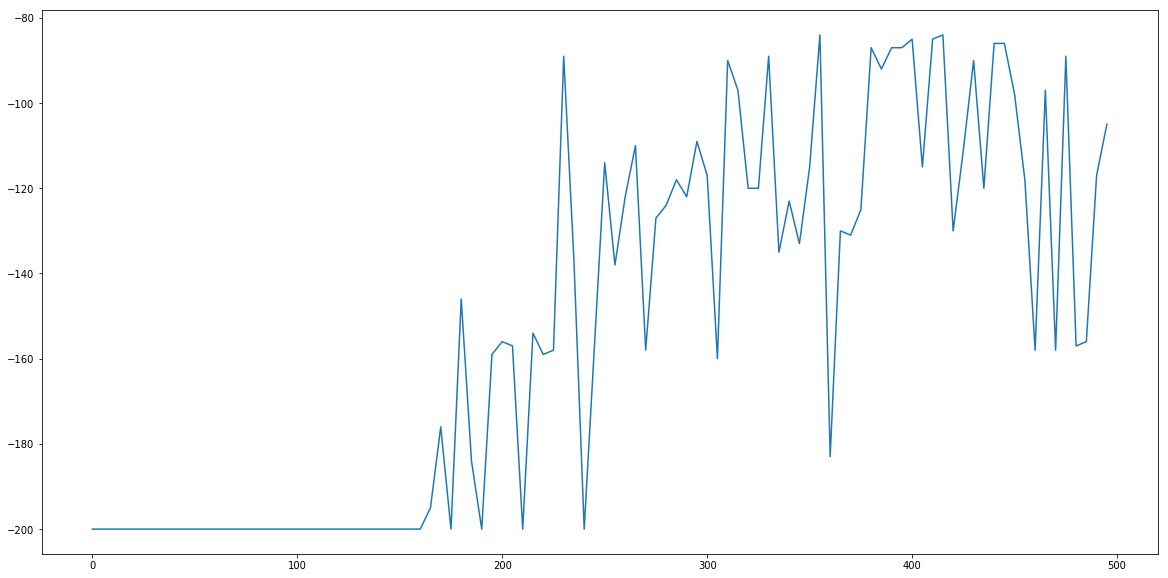

In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

every_i = 5
scores_i = scores[::every_i]
plt.plot(range(len(scores))[::every_i], scores_i);